In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy.stats.mstats import rankdata
from aslib_scenario.aslib_scenario import ASlibScenario
from sksurv.ensemble import RandomSurvivalForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from tqdm import tqdm
from matplotlib import rcParams
import matplotlib.gridspec as gridspec
import matplotlib as mpl


### Matplotlib settings ###
plt.rcParams.update(plt.rcParamsDefault)
font = {'family' : 'normal',
        'size'   : 16}

plt.rc('font', **font)
#rcParams.update({'figure.autolayout': True})
rcParams.update(mpl.rcParamsDefault)
sns.set_style('darkgrid')
sns.set_context(font_scale=5.0, rc={"lines.linewidth": 3.0})

%matplotlib inline

### Data for normalized PAR10 values

In [11]:
survival_data = pd.read_csv(r'./clipped_survival_normalized_par10.csv')
survival_data.columns = ['ASlib Scenarios', 'Algorithm Selector', 'metric', 'normalized', 'num_results']

name_map = {'ExpectationSurvivalForest':'Run2SurviveExp', 'RiskAverseSurvivalForest':'Run2SurvivePoly/Log', 'PAR10SurvivalForest':'Run2SurvivePAR10'}
survival_data = survival_data.replace(name_map)
survival_data = survival_data[survival_data['Algorithm Selector'] !='GridSearchSurvivalForest']
survival_data.to_csv(r'./run2survive_normalized_par10.csv', index=False)

,ASlib Scenarios,Algorithm Selector,metric,normalized,num_results
0,ASP-POTASSCO,Run2SurviveExp,par10,0.300748,10
1,ASP-POTASSCO,Run2SurvivePoly/Log,par10,0.305577,10
2,ASP-POTASSCO,Run2SurvivePAR10,par10,0.342333,10
3,BNSL-2016,Run2SurvivePoly/Log,par10,0.192756,10
4,BNSL-2016,Run2SurviveExp,par10,0.204385,10
...,...,...,...,...,...
73,SAT15-INDU,Run2SurviveExp,par10,1.010693,10
74,SAT15-INDU,Run2SurvivePoly/Log,par10,1.011687,10
75,TSP-LION2015,Run2SurviveExp,par10,2.576624,10
76,TSP-LION2015,Run2SurvivePAR10,par10,2.616750,10


In [15]:
### For each baseline select results from the overall best setting (PAR10, Runtime or Ignored) in terms of median performance aggregated over all scenarios 
# get data for own approaches from normalize par10 table
survival_data = pd.read_csv(r'./run2survive_normalized_par10.csv')
survival_data.columns = ['ASlib Scenarios', 'Algorithm Selector', 'metric', 'normalized', 'num_results']
#num_approaches = data['Algorithm Selector'].nunique()
survival_data = survival_data.pivot('ASlib Scenarios','Algorithm Selector','normalized')
survival_data = survival_data[['Run2SurviveExp', 'Run2SurvivePAR10', 'Run2SurvivePoly/Log']]

# get data for baselines from the comparison par10 table (best value from different settings)
baseline_data =  pd.read_csv(r'./setting_comparison_normalized_par10.csv')
min_median_setting = baseline_data.groupby(['Algorithm Selector', 'Metric']).median().idxmin(axis=1)
min_median_setting = min_median_setting.droplevel(level=1)
min_median_setting = list(zip(min_median_setting.index, min_median_setting))
baseline_map = dict(min_median_setting).copy()
baseline_data = baseline_data.pivot('ASlib Scenario', 'Algorithm Selector', ['PAR10', 'Runtime', 'Ignored']).swaplevel(axis=1).sort_index(1)
baseline_data = baseline_data[min_median_setting]
baseline_data = baseline_data.droplevel(axis=1, level=1)

# add Schmee & Hahn for PerAlgorithmRegressor and recompute min median
schmee_data = pd.read_csv(r'./schmee_normalized_par10.csv')
schmee_data = schmee_data[schmee_data['Algorithm Selector'] == 'ImputedPerAlgorithmRegressor']
schmee_data = schmee_data.set_index(keys='ASlib Scenario', drop=True)
if schmee_data['normalized'].median() < baseline_data['PerAlgorithmRegressor'].median():
    baseline_data['PerAlgorithmRegressor'] = schmee_data['normalized']
    baseline_map['PerAlgorithmRegressor'] = 'S & H'
    
# adjust ordering of algorithms
baseline_data = baseline_data[['PerAlgorithmRegressor', 'MultiClassSelector', 'ISAC*like', 'SATzilla\'11*like', 'SUNNY*like']]

data = pd.concat([survival_data, baseline_data], axis = 1).T.drop_duplicates().T
baseline_index = [''.join([selector, '\n(' + baseline_map[selector] + ')']) for selector in data.columns if selector in baseline_map.keys()]
baseline_index = [selector  if not selector.startswith('MultiClassSelector') else 'MultiClassSelector' for selector in baseline_index]
data = data.rename(columns={selector: ''.join([selector, '\n(' + setting + ')']) for selector, setting in baseline_map.items() if selector != 'MultiClassSelector'})
data.head()

Algorithm Selector,Run2SurviveExp,Run2SurvivePAR10,Run2SurvivePoly/Log,PerAlgorithmRegressor\n(Runtime),MultiClassSelector,ISAC*like\n(PAR10),SATzilla'11*like\n(Runtime),SUNNY*like\n(Runtime)
ASP-POTASSCO,0.300748,0.342333,0.305577,0.317374,0.666993,0.652729,0.468827,0.198078
BNSL-2016,0.204385,0.222191,0.192756,0.176564,0.314813,0.832608,0.176326,0.241465
CPMP-2015,0.973395,0.812111,0.927753,0.909551,0.935870,0.978148,0.851140,0.987723
CSP-2010,0.259283,0.259996,0.243043,0.356102,0.781660,0.370574,0.295024,0.342054
CSP-MZN-2013,0.111204,0.114682,0.111474,0.125198,0.310290,0.341374,0.207207,0.135190


### Heatmap for normalized PAR10 values

### Heatmap for Survival Forest vs Baselines comparison

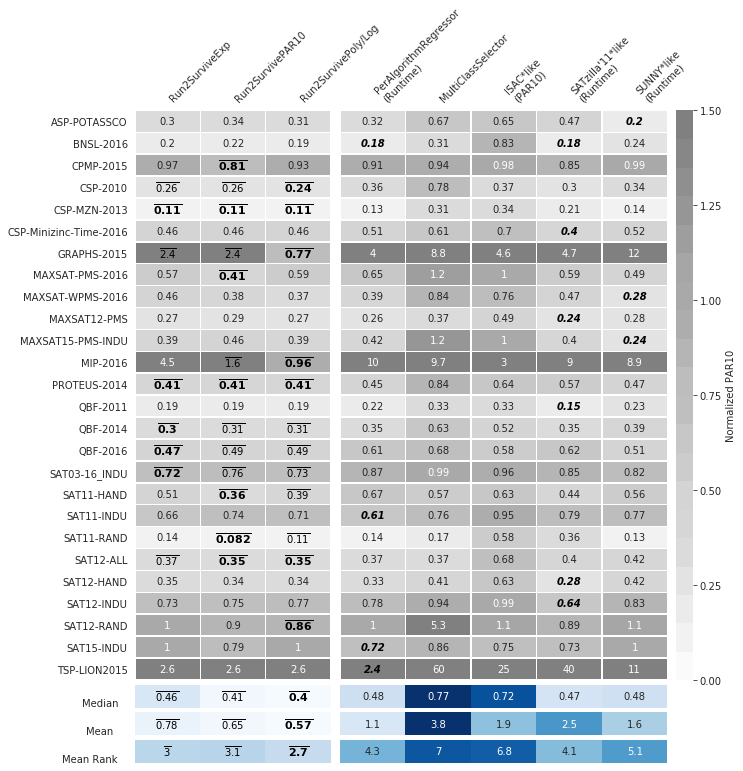

In [16]:
survival_algorithms = ['Run2SurviveExp', 'Run2SurvivePAR10', 'Run2SurvivePoly/Log']
baselines = ['PerAlgorithmRegressor\n(Runtime)', 'MultiClassSelector',       'ISAC*like\n(PAR10)', 'SATzilla\'11*like\n(Runtime)','SUNNY*like\n(Runtime)']
approaches = survival_algorithms + baselines
num_survival_algorithms = len(survival_algorithms)
num_baselines = len(baselines)
num_scenarios, num_algorithms = data.values.shape

fig = plt.figure(figsize=(10, 12), constrained_layout=False)
gs = gridspec.GridSpec(4, 3, width_ratios=[30, 50, 2.5], height_ratios=[125, 5, 5, 5], figure=fig, wspace=0.05, hspace=0.03)
ax1_1 = fig.add_subplot(gs[0, 0])
ax1_2 = fig.add_subplot(gs[0, 1])
ax1_3 = fig.add_subplot(gs[0, 2])

ax2_1 = fig.add_subplot(gs[1, 0])
ax2_2 = fig.add_subplot(gs[1, 1])

ax3_1 = fig.add_subplot(gs[2, 0])
ax3_2 = fig.add_subplot(gs[2, 1])

ax4_1 = fig.add_subplot(gs[3, 0])
ax4_2 = fig.add_subplot(gs[3, 1])

normal_vmax = 1.5
palette = sns.color_palette(['#FAFAFA', '#F2F2F2', '#EBEBEB', '#E3E3E3', '#DBDBDB', '#D6D6D6', '#D4D4D4', '#CCCCCC', '#C7C7C7', '#BFBFBF', '#BDBDBD', '#B5B5B5', '#ADADAD', '#A9A9A9', '#A6A6A6', '#9E9E9E', '#969696', '#8F8F8F', '#878787', '#808080'], n_colors=20)


tmp_data = data[survival_algorithms]
heatmap = sns.heatmap(tmp_data, cmap=palette, linewidths=.5, ax=ax1_1, annot=True, cbar_kws={'label': 'Normalized PAR10'}, vmax=normal_vmax, vmin=0.0, cbar=False)
ax1_1.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, top=False, labeltop=True)
labels = ax1_1.get_xticklabels()
ax1_1.set_xticklabels(labels, rotation=45, ha='left')
ax1_1.set_xlabel('')
ax1_1.set_ylabel('')


tmp_data = data[baseline_index]
heatmap = sns.heatmap(tmp_data, cmap=palette, linewidths=.5, ax=ax1_2, annot=True, cbar_kws={'label': 'Normalized PAR10'}, vmax=normal_vmax, vmin=0.0, cbar_ax=ax1_3)

ax1_2.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, top=False, labeltop=True)
ax1_2.axes.get_yaxis().set_visible(False)
labels = ax1_2.get_xticklabels()
ax1_2.set_xticklabels(labels, rotation=45, ha='left')
ax1_2.set_xlabel('')
ax1_2.set_ylabel('')



for scenario_id in range(num_scenarios):
    tmp_1 = ax1_1.texts[scenario_id * num_survival_algorithms: scenario_id * num_survival_algorithms + num_survival_algorithms]    
    tmp_2 = ax1_2.texts[scenario_id * num_baselines: scenario_id * num_baselines + num_baselines]
    min_val = min(min([float(text.get_text()) for text in tmp_1]), min([float(text.get_text()) for text in tmp_2]))
    min_baseline_val = min([float(text.get_text()) for text in tmp_2])
    indices_1_underline = [num for num, text in enumerate(tmp_1) if float(text.get_text()) <= min_baseline_val]
    indices_1 = [num for num, text in enumerate(tmp_1) if float(text.get_text()) == min_val]
    indices_2 = [num for num, text in enumerate(tmp_2) if float(text.get_text()) == min_val]
    
    for idx in set(indices_1_underline).intersection(set(indices_1)):
        text = tmp_1[idx]
        text.set_text(r'$\mathbf{\overline{%s}}$' % text.get_text())
        text.set_size(11)
        text.set_color('black')
        text.set_style('italic')
        
    for idx in set(indices_1_underline).difference(set(indices_1)):
        text = tmp_1[idx]
        text.set_text(r'$\overline{%s}$' % text.get_text())
        text.set_color('black')
        text.set_style('italic')
        
                
    for idx in indices_2:
        text = tmp_2[idx]
        #text.set_size(14)
        text.set_weight('bold')
        text.set_color('black')
        text.set_style('italic')     

bottom_palette =sns.color_palette("Blues", n_colors=100)

ax2_data = np.median(data[approaches].values, axis=0)
ax2_data = ax2_data.reshape(1, ax2_data.size)
ax2_vmin, ax2_vmax = np.nanmin(ax2_data), np.nanmax(ax2_data)
sns.heatmap(ax2_data[:, :num_survival_algorithms], ax=ax2_1, annot=True, cbar=False, xticklabels=False, yticklabels=False, cmap=bottom_palette, vmin=ax2_vmin, vmax=ax2_vmax)
ax2_1.set_ylabel('Median', rotation=0, labelpad=35, y=-0.05)
sns.heatmap(ax2_data[:, num_survival_algorithms:], ax=ax2_2, annot=True, cbar=False, xticklabels=False, yticklabels=False, cmap=bottom_palette, vmin=ax2_vmin, vmax=ax2_vmax)
ax2_2.set_ylabel('')

min_val = min(min([float(text.get_text()) for text in ax2_1.texts]), min([float(text.get_text()) for text in ax2_2.texts]))
indices_1 = [num for num, text in enumerate(ax2_1.texts) if float(text.get_text()) == min_val]
indices_2 = [num for num, text in enumerate(ax2_2.texts) if float(text.get_text()) == min_val]

min_baseline_val = min([float(text.get_text()) for text in ax2_2.texts])
indices_1_underline = [num for num, text in enumerate(ax2_1.texts) if float(text.get_text()) <= min_baseline_val]

for idx in set(indices_1_underline).intersection(set(indices_1)):
    text = ax2_1.texts[idx]
    text.set_text(r'$\mathbf{\overline{%s}}$' % text.get_text())
    text.set_size(11)
    text.set_color('black')
    text.set_style('italic')

for idx in set(indices_1_underline).difference(set(indices_1)):
    text = ax2_1.texts[idx]
    text.set_text(r'$\overline{%s}$' % text.get_text())
    text.set_color('black')
    text.set_style('italic')

for idx in indices_2:
    text = ax2_2.texts[idx]
    #text.set_size(14)
    text.set_weight('bold')
    text.set_color('black')
    text.set_style('italic')


ax3_data = np.mean(data[approaches].values, axis=0)
ax3_data = ax3_data.reshape(1, ax3_data.size)
ax3_vmin, ax3_vmax = np.nanmin(ax3_data), np.nanmax(ax3_data)
sns.heatmap(ax3_data[:, :num_survival_algorithms], ax=ax3_1, annot=True, cbar=False, xticklabels=False, yticklabels=False, cmap=bottom_palette, vmin=ax3_vmin, vmax=ax3_vmax)
ax3_1.set_ylabel('Mean', rotation=0, labelpad=35, y=-0.05)
sns.heatmap(ax3_data[:, num_survival_algorithms:], ax=ax3_2, annot=True, cbar=False, xticklabels=False, yticklabels=False, cmap=bottom_palette, vmin=ax3_vmin, vmax=ax3_vmax)
ax3_2.set_ylabel('')


min_val = min(min([float(text.get_text()) for text in ax3_1.texts]), min([float(text.get_text()) for text in ax3_2.texts]))
indices_1 = [num for num, text in enumerate(ax3_1.texts) if float(text.get_text()) == min_val]
indices_2 = [num for num, text in enumerate(ax3_2.texts) if float(text.get_text()) == min_val]

min_baseline_val = min([float(text.get_text()) for text in ax3_2.texts])
indices_1_underline = [num for num, text in enumerate(ax3_1.texts) if float(text.get_text()) <= min_baseline_val]

for idx in set(indices_1_underline).intersection(set(indices_1)):
    text = ax3_1.texts[idx]
    text.set_text(r'$\mathbf{\overline{%s}}$' % text.get_text())
    text.set_size(11)
    text.set_color('black')
    text.set_style('italic')

for idx in set(indices_1_underline).difference(set(indices_1)):
    text = ax3_1.texts[idx]
    text.set_text(r'$\overline{%s}$' % text.get_text())
    text.set_color('black')
    text.set_style('italic')

for idx in indices_2:
    text = ax3_2.texts[idx]
    #text.set_size(14)
    text.set_weight('bold')
    text.set_color('black')
    text.set_style('italic')


ax4_data = rankdata(data[approaches].values, axis=1)
ax4_data = np.mean(ax4_data, axis=0)
ax4_data = ax4_data.reshape(1, ax4_data.size)
ax4_vmin, ax4_vmax = 1, np.size(ax4_data, axis=1)
sns.heatmap(ax4_data[:, :num_survival_algorithms], ax=ax4_1, annot=True, cbar=False, xticklabels=False, yticklabels=False, cmap=bottom_palette, vmin=ax4_vmin, vmax=ax4_vmax)
ax4_1.set_ylabel('Mean Rank', rotation=0, labelpad=45, y=-0.05)
sns.heatmap(ax4_data[:, num_survival_algorithms:], ax=ax4_2, annot=True, cbar=False, xticklabels=False, yticklabels=False, cmap=bottom_palette, vmin=ax4_vmin, vmax=ax4_vmax)
ax4_2.set_ylabel('')

min_val = min(min([float(text.get_text()) for text in ax4_1.texts]), min([float(text.get_text()) for text in ax4_2.texts]))
indices_1 = [num for num, text in enumerate(ax4_1.texts) if float(text.get_text()) == min_val]
indices_2 = [num for num, text in enumerate(ax4_2.texts) if float(text.get_text()) == min_val]

min_baseline_val = min([float(text.get_text()) for text in ax4_2.texts])
indices_1_underline = [num for num, text in enumerate(ax4_1.texts) if float(text.get_text()) <= min_baseline_val]

for idx in set(indices_1_underline).intersection(set(indices_1)):
    text = ax4_1.texts[idx]
    text.set_text(r'$\mathbf{\overline{%s}}$' % text.get_text())
    text.set_size(11)
    text.set_color('black')
    text.set_style('italic')

for idx in set(indices_1_underline).difference(set(indices_1)):
    text = ax4_1.texts[idx]
    text.set_text(r'$\overline{%s}$' % text.get_text())
    text.set_color('black')
    text.set_style('italic')

for idx in indices_2:
    text = ax4_2.texts[idx]
    #text.set_size(14)
    text.set_weight('bold')
    text.set_color('black')
    text.set_style('italic')


fig.savefig(r'./run2survive_normalized_par10_heatmap.pdf', bbox_inches='tight')
fig.show()

 ### Separate heatmaps for normalized PAR10 values

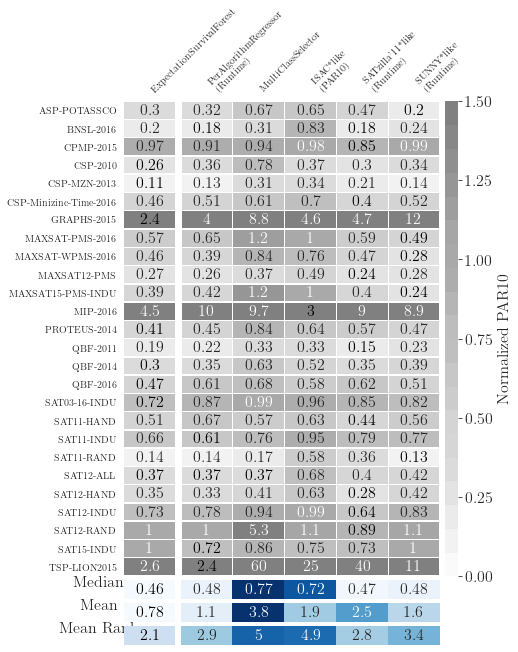

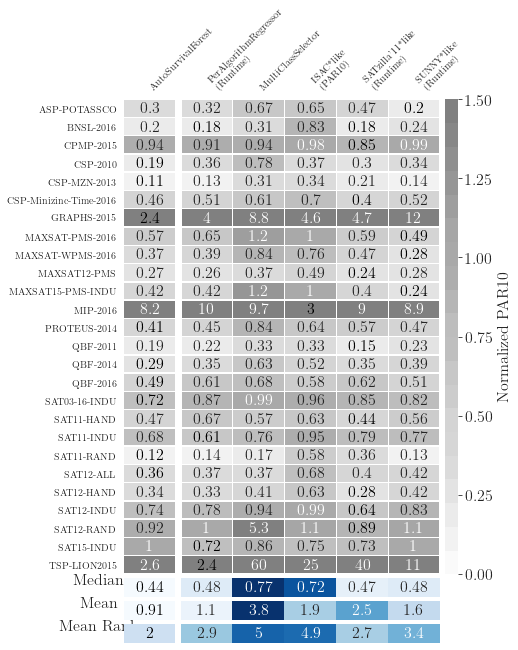

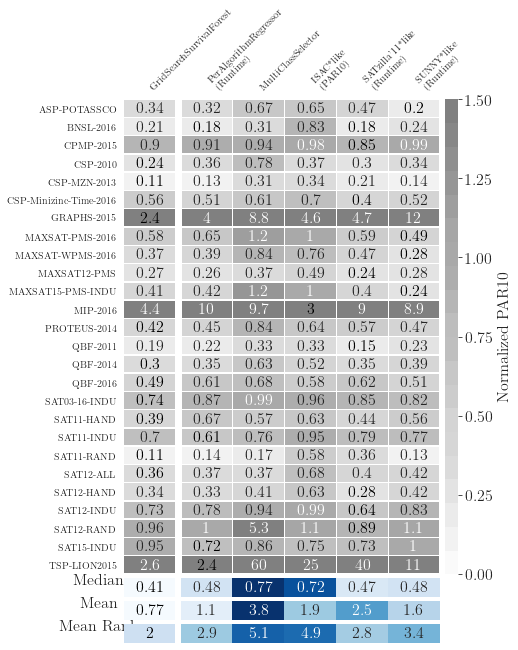

In [66]:
survival_forest_list = ['ExpectationSurvivalForest', 'AutoSurvivalForest', 'GridSearchSurvivalForest']
baselines = ['PerAlgorithmRegressor\n(Runtime)', 'MultiClassSelector', 'ISAC*like\n(PAR10)', 'SATzilla\'11*like\n(Runtime)', 'SUNNY*like\n(Runtime)']
num_survival_approaches = len(survival_forest_list)

for survival_forest in survival_forest_list:

    fig = plt.figure(figsize=(6, 10), constrained_layout=False)
    gs = gridspec.GridSpec(4, 3, width_ratios=[10, 50, 2.5], height_ratios=[125, 5, 5, 5], figure=fig, wspace=0.05, hspace=0.03)
    ax1_1 = fig.add_subplot(gs[0, 0])
    ax1_2 = fig.add_subplot(gs[0, 1])
    ax1_3 = fig.add_subplot(gs[0, 2])

    ax2_1 = fig.add_subplot(gs[1, 0])
    ax2_2 = fig.add_subplot(gs[1, 1])

    ax3_1 = fig.add_subplot(gs[2, 0])
    ax3_2 = fig.add_subplot(gs[2, 1])

    ax4_1 = fig.add_subplot(gs[3, 0])
    ax4_2 = fig.add_subplot(gs[3, 1])

    normal_vmax = 1.5
    palette = sns.color_palette(['#FAFAFA', '#F2F2F2', '#EBEBEB', '#E3E3E3', '#DBDBDB', '#D6D6D6', '#D4D4D4', '#CCCCCC', '#C7C7C7', '#BFBFBF', '#BDBDBD', '#B5B5B5', '#ADADAD', '#A9A9A9', '#A6A6A6', '#9E9E9E', '#969696', '#8F8F8F', '#878787', '#808080'], n_colors=20)


    tmp_data = data[[survival_forest]]
    heatmap = sns.heatmap(tmp_data, cmap=palette, linewidths=.5, ax=ax1_1, annot=True, cbar_kws={'label': 'Normalized PAR10'}, vmax=normal_vmax, vmin=0.0, cbar=False)
    ax1_1.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, top=False, labeltop=True)
    labels = ax1_1.get_xticklabels()
    ax1_1.set_xticklabels(labels, rotation=45, ha='left')
    ax1_1.set_xlabel('')
    ax1_1.set_ylabel('')


    tmp_data = data[baseline_index]
    heatmap = sns.heatmap(tmp_data, cmap=palette, linewidths=.5, ax=ax1_2, annot=True, cbar_kws={'label': 'Normalized PAR10'}, vmax=normal_vmax, vmin=0.0, cbar_ax=ax1_3)

    ax1_2.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, top=False, labeltop=True)
    ax1_2.axes.get_yaxis().set_visible(False)
    labels = ax1_2.get_xticklabels()
    ax1_2.set_xticklabels(labels, rotation=45, ha='left')
    ax1_2.set_xlabel('')
    ax1_2.set_ylabel('')


    # WORAROUND TO A BUG IN MATPLOTLIB 3.1.1 WHERE THE FIRST AND LAST ROW OF THE HEATMAP ARE CUT
    #bottom, top = ax1_1.get_ylim()
    #ax1_1.set_ylim(bottom + 0.5, top - 0.5)
    #bottom, top = ax1_2.get_ylim()
    #ax1_2.set_ylim(bottom + 0.5, top - 0.5)


    num_scenarios, num_algorithms = data.values.shape
    for scenario_id in range(num_scenarios):
        tmp_1 = ax1_1.texts[scenario_id * 1: scenario_id * 1 + 1]    
        tmp_2 = ax1_2.texts[scenario_id * 5: scenario_id * 5 + 5]
        min_val = min(min([float(text.get_text()) for text in tmp_1]), min([float(text.get_text()) for text in tmp_2]))
        indices_1 = [num for num, text in enumerate(tmp_1) if float(text.get_text()) == min_val]
        indices_2 = [num for num, text in enumerate(tmp_2) if float(text.get_text()) == min_val]

        for idx in indices_1:
            text = tmp_1[idx]
            #text.set_size(14)
            text.set_weight('bold')
            text.set_color('black')
            text.set_style('italic')

        for idx in indices_2:
            text = tmp_2[idx]
            #text.set_size(14)
            text.set_weight('bold')
            text.set_color('black')
            text.set_style('italic')     

    bottom_palette =sns.color_palette("Blues", n_colors=100)
    tmp_cols = [survival_forest] + baselines
    tmp_data = data[tmp_cols]
    
    
    ax2_data = np.median(tmp_data.values, axis=0)
    ax2_data = ax2_data.reshape(1, ax2_data.size)

    ax2_vmin, ax2_vmax = np.nanmin(ax2_data), np.nanmax(ax2_data)
    sns.heatmap(ax2_data[:, :1], ax=ax2_1, annot=True, cbar=False, xticklabels=False, yticklabels=False, cmap=bottom_palette, vmin=ax2_vmin, vmax=ax2_vmax)
    ax2_1.set_ylabel('Median', rotation=0, labelpad=25)
    sns.heatmap(ax2_data[:, 1:], ax=ax2_2, annot=True, cbar=False, xticklabels=False, yticklabels=False, cmap=bottom_palette, vmin=ax2_vmin, vmax=ax2_vmax)
    ax2_2.set_ylabel('')

    min_val = min(min([float(text.get_text()) for text in ax2_1.texts]), min([float(text.get_text()) for text in ax2_2.texts]))
    indices_1 = [num for num, text in enumerate(ax2_1.texts) if float(text.get_text()) == min_val]
    indices_2 = [num for num, text in enumerate(ax2_2.texts) if float(text.get_text()) == min_val]

    for idx in indices_1:
        text = ax2_1.texts[idx]
        #text.set_size(14)
        text.set_weight('bold')
        text.set_color('black')
        text.set_style('italic')

    for idx in indices_2:
        text = ax2_2.texts[idx]
        #text.set_size(14)
        text.set_weight('bold')
        text.set_color('black')
        text.set_style('italic')


    ax3_data = np.mean(tmp_data.values, axis=0)
    ax3_data = ax3_data.reshape(1, ax3_data.size)
    ax3_vmin, ax3_vmax = np.nanmin(ax3_data), np.nanmax(ax3_data)
    sns.heatmap(ax3_data[:, :1], ax=ax3_1, annot=True, cbar=False, xticklabels=False, yticklabels=False, cmap=bottom_palette, vmin=ax3_vmin, vmax=ax3_vmax)
    ax3_1.set_ylabel('Mean', rotation=0, labelpad=25)
    sns.heatmap(ax3_data[:, 1:], ax=ax3_2, annot=True, cbar=False, xticklabels=False, yticklabels=False, cmap=bottom_palette, vmin=ax3_vmin, vmax=ax3_vmax)
    ax3_2.set_ylabel('')


    min_val = min(min([float(text.get_text()) for text in ax3_1.texts]), min([float(text.get_text()) for text in ax3_2.texts]))
    indices_1 = [num for num, text in enumerate(ax3_1.texts) if float(text.get_text()) == min_val]
    indices_2 = [num for num, text in enumerate(ax3_2.texts) if float(text.get_text()) == min_val]

    for idx in indices_1:
        text = ax3_1.texts[idx]
        #text.set_size(14)
        text.set_weight('bold')
        text.set_color('black')
        text.set_style('italic')

    for idx in indices_2:
        text = ax3_2.texts[idx]
        #text.set_size(14)
        text.set_weight('bold')
        text.set_color('black')
        text.set_style('italic')

    ax4_data = rankdata(tmp_data.values, axis=1)
    ax4_data = np.mean(ax4_data, axis=0)
    ax4_data = ax4_data.reshape(1, ax4_data.size)
    ax4_vmin, ax4_vmax = 1, np.size(ax4_data, axis=1)
    sns.heatmap(ax4_data[:, :1], ax=ax4_1, annot=True, cbar=False, xticklabels=False, yticklabels=False, cmap=bottom_palette, vmin=ax4_vmin, vmax=ax4_vmax)
    ax4_1.set_ylabel('Mean Rank', rotation=0, labelpad=25)
    sns.heatmap(ax4_data[:, 1:], ax=ax4_2, annot=True, cbar=False, xticklabels=False, yticklabels=False, cmap=bottom_palette, vmin=ax4_vmin, vmax=ax4_vmax)
    ax4_2.set_ylabel('')


    min_val = min(min([float(text.get_text()) for text in ax4_1.texts]), min([float(text.get_text()) for text in ax4_2.texts]))
    indices_1 = [num for num, text in enumerate(ax4_1.texts) if float(text.get_text()) == min_val]
    indices_2 = [num for num, text in enumerate(ax4_2.texts) if float(text.get_text()) == min_val]

    for idx in indices_1:
        text = ax4_1.texts[idx]
        #text.set_size(14)
        text.set_weight('bold')
        text.set_color('black')
        text.set_style('italic')

    for idx in indices_2:
        text = ax4_2.texts[idx]
        #text.set_size(14)
        text.set_weight('bold')
        text.set_color('black')
        text.set_style('italic')
        
    fig.savefig(r'./heatmap_' + survival_forest + '.pdf', bbox_inches='tight')
    fig.show()

# Fit Survival Forest on QBF-2011

In [20]:
##### Load ASlib Scenario #####
scenario_name = 'QBF-2011'
fold = 1
scenario = ASlibScenario()
scenario.read_scenario('/workspaces/aslib/' + scenario_name)
test_scenario, train_scenario = scenario.get_split(indx=fold)
num_algorithms = len(train_scenario.algorithms)
num_instances = train_scenario.instances
algorithm_cutoff_time = train_scenario.algorithm_cutoff_time
features = train_scenario.feature_data.to_numpy()
performances = train_scenario.performance_data.to_numpy()


##### Fit Random Survival Forest #####
def construct_dataset_for_algorithm_id(instance_features, performances, algorithm_id: int,
                                           algorithm_cutoff_time):
    # get runtimes of algorithm 
    performances_of_algorithm_with_id = performances.iloc[:, algorithm_id].to_numpy() if isinstance(performances, pd.DataFrame) else performances[:, algorithm_id]
    num_instances = len(performances_of_algorithm_with_id)

    # for each instance determine whether it was finished before cutoff; also set PAR10 values
    finished_before_timeout = np.empty(num_instances, dtype=bool)
    for i in range(0, len(performances_of_algorithm_with_id)):
        finished_before_timeout[i] = True if (performances_of_algorithm_with_id[i] < algorithm_cutoff_time) else False
        if performances_of_algorithm_with_id[i] >= algorithm_cutoff_time:
            performances_of_algorithm_with_id[i] = (algorithm_cutoff_time * 10)

    # for each instance build target, consisting of (censored, runtime)
    status_and_performance_of_algorithm_with_id = np.empty(dtype=[('cens', np.bool), ('time', np.float)],
                                                           shape=instance_features.shape[0])
    status_and_performance_of_algorithm_with_id['cens'] = finished_before_timeout
    status_and_performance_of_algorithm_with_id['time'] = performances_of_algorithm_with_id

    if isinstance(instance_features, pd.DataFrame):
        instance_features = instance_features.to_numpy()

    return instance_features, status_and_performance_of_algorithm_with_id.T


imputer = [SimpleImputer() for _ in range(num_algorithms)]
scaler = [StandardScaler() for _ in range(num_algorithms)]
params = {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 15, 'min_weight_fraction_leaf': 0.0, 'max_features': 'sqrt', 'bootstrap': True, 'oob_score': False}
models = [RandomSurvivalForest(n_estimators=params['n_estimators'],
                         min_samples_split=params['min_samples_split'],
                         min_samples_leaf=params['min_samples_leaf'],
                         min_weight_fraction_leaf = params['min_weight_fraction_leaf'],
                         max_features=params['max_features'],
                         bootstrap = params['bootstrap'],
                         oob_score= params['oob_score'],
                         n_jobs=1,
                         random_state=fold) for _ in range(num_algorithms)]

for alg_id in range(num_algorithms):
    # prepare survival forest dataset and split the data accordingly
    X_train, Y_train = construct_dataset_for_algorithm_id(features, performances, alg_id, algorithm_cutoff_time)            
    X_train = imputer[alg_id].fit_transform(features)
    X_train = scaler[alg_id].fit_transform(X_train)
    models[alg_id].fit(X_train, Y_train)

    
##### Predict Survival Functions and respective Risks #####
instance_id = 6
features = test_scenario.feature_data.to_numpy()[instance_id]

event_times = []
survival_functions = []

for alg_id in range(num_algorithms):
    X_test = np.reshape(features, (1, -1))
    X_test = imputer[alg_id].transform(X_test)
    X_test = scaler[alg_id].transform(X_test)
    event_times.append(models[alg_id].event_times_)
    survival_functions.append(models[alg_id].predict_survival_function(X_test)[0])

for alg_id in range(num_algorithms):
    event_times[alg_id] = np.append(0.0, event_times[alg_id])
    event_times[alg_id] = np.append(event_times[alg_id], algorithm_cutoff_time)
    survival_functions[alg_id] = np.append(1.0, survival_functions[alg_id])
    
    # Repeat last survival probability for plot
    survival_functions[alg_id] = np.append(survival_functions[alg_id], survival_functions[alg_id][-1])


Optional file not found: /workspaces/aslib/QBF-2011/ground_truth.arff
Optional file not found: /workspaces/aslib/QBF-2011/feature_costs.arff
Have not found features_cutoff_time
Have not found features_cutoff_memory
Have not found features_stochastic
Found 114 duplicated feature vectors
Index(['C880.blif_0.10_0.20_0_0_out_exact',
       'C880.blif_0.10_0.20_0_1_out_exact',
       'Core1108_tbm_02.tex.moduleQ3.2S.000007',
       'Core1108_tbm_02.tex.moduleQ3.2S.000077',
       'Core1108_tbm_02.tex.moduleQ3.2S.000099',
       'Core1108_tbm_02.tex.moduleQ3.2S.000108',
       'Core1108_tbm_03.tex.module.000038',
       'Core1108_tbm_03.tex.module.000039',
       'Core1108_tbm_03.tex.moduleQ3.2S.000002',
       'Core1108_tbm_03.tex.moduleQ3.2S.000009',
       ...
       'robots_1_5_5_8.4', 'robots_1_5_5_87.4', 'robots_1_5_5_93.4',
       'robots_1_5_5_95.8', 'robots_1_5_5_97.2', 'robots_1_5_5_99.8',
       'test1_quant2', 'test1_quant_squaring2', 'test4_quant2',
       'test4_quant_squaring2

# Predictions, Survival Functions & Event Times

In [21]:
instance_id = 6
features = test_scenario.feature_data.to_numpy()[instance_id]

event_times = []
survival_functions = []

for alg_id in range(num_algorithms):
    X_test = np.reshape(features, (1, -1))
    X_test = imputer[alg_id].transform(X_test)
    X_test = scaler[alg_id].transform(X_test)
    event_times.append(models[alg_id].event_times_)
    survival_functions.append(models[alg_id].predict_survival_function(X_test)[0])

for alg_id in range(num_algorithms):
    event_times[alg_id] = np.append(0.0, event_times[alg_id])
    event_times[alg_id] = np.append(event_times[alg_id], algorithm_cutoff_time)
    survival_functions[alg_id] = np.append(1.0, survival_functions[alg_id])
    
    # Repeat last survival probability for plot
    survival_functions[alg_id] = np.append(survival_functions[alg_id], survival_functions[alg_id][-1])


# Survival Functions Plot

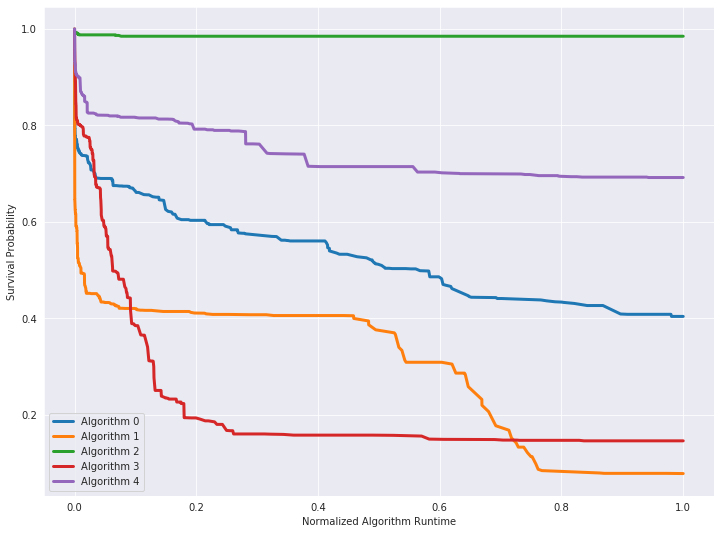

In [10]:
# set figure settings
fig, ax = plt.subplots(figsize=(12, 9))
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_ylabel('Survival Probability')
ax.set_xlabel('Normalized Algorithm Runtime')

# plot survival functions 
for alg_id in range(num_algorithms):
    events =  event_times[alg_id] / algorithm_cutoff_time
    sns.lineplot(x=events, y=survival_functions[alg_id], ax=ax, label='Algorithm {}'.format(alg_id))
    
fig.savefig(r'./survival_functions.pdf', bbox_inches='tight')
fig.show()

# Cumulated Risk Score Plots

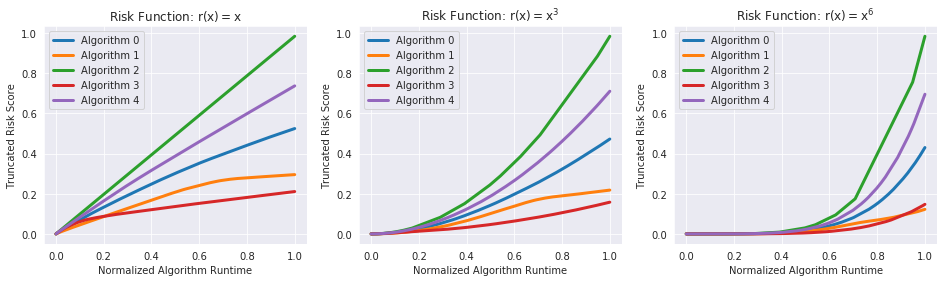

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
risk_funcs = [lambda x: x, lambda x: x**2, lambda x: x**5]
    
for ax_num, risk_func in enumerate(risk_funcs):
    axes[ax_num].ticklabel_format(useOffset=False, style='plain')
    axes[ax_num].set_ylabel('Truncated Risk Score')
    axes[ax_num].set_xlabel('Normalized Algorithm Runtime')
    if ax_num == 0:
        axes[ax_num].set_title('Risk Function: $\mathrm{r(x) = x}$')
        
    elif ax_num == 1:
        axes[ax_num].set_title('Risk Function: $\mathrm{r(x) = x^3}$')

    else:
        axes[ax_num].set_title('Risk Function: $\mathrm{r(x) = x^6}$')
    
    for alg_id in range(num_algorithms):
        events = event_times[alg_id] / algorithm_cutoff_time
        risk_scores = np.cumsum(survival_functions[alg_id][:-1] * np.diff(risk_func(events)))
        sns.lineplot(x=events[1:], y=risk_scores, ax=axes[ax_num], label='Algorithm {}'.format(alg_id))

fig.savefig(r'./risk_functions.pdf', bbox_inches='tight')
fig.show()

# Cumulated Risk Score Plots (Algorithm 1 & 3)

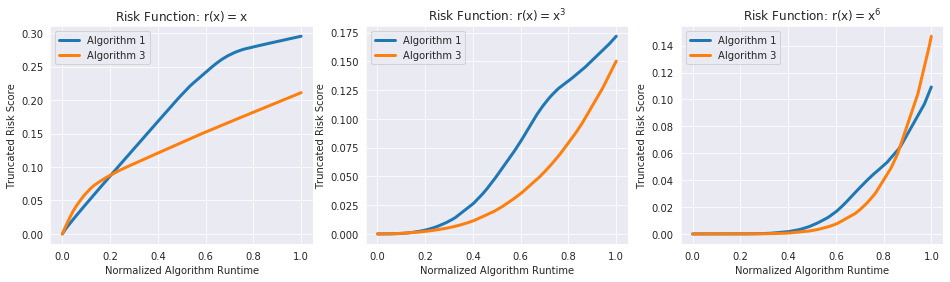

In [12]:
subset = [1, 3]

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
risk_funcs = [lambda x: x, lambda x: x**3, lambda x: x**6]
    
for ax_num, risk_func in enumerate(risk_funcs):
    axes[ax_num].ticklabel_format(useOffset=False, style='plain')
    axes[ax_num].set_ylabel('Truncated Risk Score')
    axes[ax_num].set_xlabel('Normalized Algorithm Runtime')
    if ax_num == 0:
        axes[ax_num].set_title('Risk Function: $\mathrm{r(x) = x}$')
        
    elif ax_num == 1:
        axes[ax_num].set_title('Risk Function: $\mathrm{r(x) = x^3}$')

    else:
        axes[ax_num].set_title('Risk Function: $\mathrm{r(x) = x^6}$')
    
    for alg_id in subset:
        events = event_times[alg_id] / algorithm_cutoff_time
        risk_scores = np.cumsum(survival_functions[alg_id][:-1] * np.diff(risk_func(events)))
        sns.lineplot(x=events[1:], y=risk_scores, ax=axes[ax_num], label='Algorithm {}'.format(alg_id))
        
fig.savefig(r'./subset_risk_functions.pdf', bbox_inches='tight')
fig.show()

# Cumulated Risk Score Difference (Algorithm 1 & 3)

# Modification of Survival Functions in order to establish a clear example

In [22]:
survival_functions[1][-25:-23] = 0.20733033
survival_functions[1][-23:-20] = 0.18733033
survival_functions[1][-20:-18] = 0.1733033
survival_functions[1][-19:-16] = 0.12192181
survival_functions[1][-16:-10] = 0.080192181
survival_functions[1][-10:-7] = 0.05437217
survival_functions[1][-7:-4] = 0.03867688
survival_functions[1][-4:] = 0.0247688

# Joint Plot

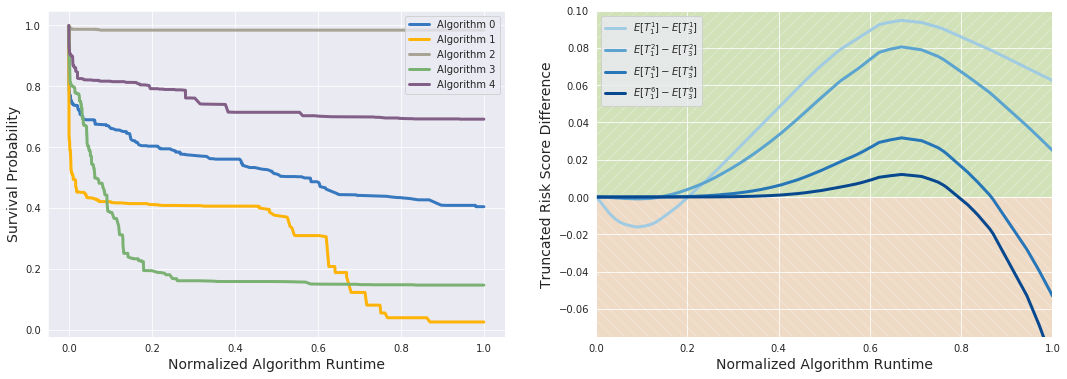

In [70]:
# set figure settings
fig, axes = plt.subplots(1, 2, figsize=(18, 6))


### Survival Plot ###
axes[0].ticklabel_format(useOffset=False, style='plain')
axes[0].set_ylabel('Survival Probability', fontsize=14)
axes[0].set_xlabel('Normalized Algorithm Runtime', fontsize=14)

colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
palette = sns.xkcd_palette(colors)

# plot survival functions 
for alg_id in range(num_algorithms):
    events =  event_times[alg_id] / algorithm_cutoff_time
    sns.lineplot(x=events, y=survival_functions[alg_id], ax=axes[0], label='Algorithm {}'.format(alg_id), color=palette[alg_id])
    
    
### Cumulated Risk Score Difference Plot ###
axes[1].set_ylim([-0.075, 0.1])
axes[1].set_xlim([0.0, 1.0])


subset = [1, 3]
alg_0 = subset[0]
alg_1 = subset[1]

axes[1].ticklabel_format(useOffset=False, style='plain')
axes[1].set_ylabel('Truncated Risk Score Difference',  fontsize=14)
axes[1].set_xlabel('Normalized Algorithm Runtime', fontsize=14)

# compute all events occuring for algorithm 1 and algorithm 3
overall_events = set(event for alg_id in subset for event in event_times[alg_id].tolist())
overall_events.update([0.0, algorithm_cutoff_time])
overall_events = sorted(overall_events)

# compute all respective differences regarding the algorithms' survival probabilities
difference = np.zeros(len(overall_events))
for event_idx, event in enumerate(overall_events):
    # get index of respective survival probability for each algorithm
    idx = np.zeros(len(subset), dtype=int)
    for num, alg_id in enumerate(subset):
        idx[num] = np.argmax(event_times[alg_id] >= event)

    difference[event_idx] = survival_functions[alg_0][idx[0]] - survival_functions[alg_1][idx[1]]
    
overall_events = np.asarray(overall_events) / algorithm_cutoff_time

y1 = np.cumsum(difference[1:] * np.diff(overall_events**1.0))
y2 = np.cumsum(difference[1:] * np.diff(overall_events**2.0))
y3 = np.cumsum(difference[1:] * np.diff(overall_events**4.0)) 
y4 = np.cumsum(difference[1:] * np.diff(overall_events**6.0))

palette = sns.color_palette("Blues", 10)

sns.lineplot(x=overall_events[1:], y=y1, ax=axes[1], label='$E[T_1^1] - E[T_3^1]$', color=palette[3])
sns.lineplot(x=overall_events[1:], y=y2, ax=axes[1], label='$E[T_1^2] - E[T_3^2]$', color=palette[5])
sns.lineplot(x=overall_events[1:], y=y3, ax=axes[1], label='$E[T_1^4] - E[T_3^4]$', color=palette[7])
sns.lineplot(x=overall_events[1:], y=y4, ax=axes[1], label='$E[T_1^6] - E[T_3^6]$', color=palette[9])

#fb1 = axes[1].fill_between([0.0, 1.0], y1=[0.0, 0.0], y2=[0.1, 0.1], facecolor="#f03838", zorder=0, alpha=0.3)
fb1 = axes[1].fill_between([0.0, 1.0], y1=[0.0, 0.0], y2=[0.1, 0.1], facecolor="#9ACD32", zorder=0, alpha=0.3)
fb1.set_hatch('//')

fb2 = axes[1].fill_between([0.0, 1.0], y1=[0.0, 0.0], y2=[-2.0, -2.0], facecolor="#fab75d", zorder=0, alpha=0.3)
fb2.set_hatch("\\\\")

fig.savefig(r'./joint_plot.pdf', bbox_inches='tight')
fig.show()

# KDE plot

/opt/conda/envs/survival/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log
/opt/conda/envs/survival/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in multiply


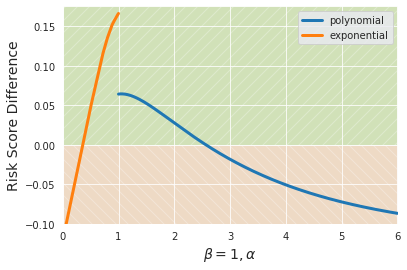

In [44]:
alg_1 = 1
alg_2 = 3

diffs_poly = []
diffs_exp = []
alpha_range_poly = np.linspace(1,6,10000)
alpha_range_exp = np.linspace(0,1,10000)

for alpha in alpha_range_poly:
    risk_func_poly = lambda x: x**alpha
    
    events_1 = event_times[alg_1] / algorithm_cutoff_time
    events_2 = event_times[alg_2] / algorithm_cutoff_time
    
    risk_score_1_poly = np.sum(survival_functions[alg_1][:-1] * np.diff(risk_func_poly(events_1)))
    risk_score_2_poly = np.sum(survival_functions[alg_2][:-1] * np.diff(risk_func_poly(events_2)))
    
    diffs_poly.append(risk_score_1_poly - risk_score_2_poly)
    
for alpha in alpha_range_exp:
    exp_thresh = 1
    risk_func_exp =  lambda x: np.minimum((-1) * alpha * np.log(1.0 - x), exp_thresh)

    events_1 = event_times[alg_1] / algorithm_cutoff_time
    events_2 = event_times[alg_2] / algorithm_cutoff_time

    risk_score_1_exp = np.sum(survival_functions[alg_1][:-1] * np.diff(risk_func_exp(events_1)))
    risk_score_2_exp = np.sum(survival_functions[alg_2][:-1] * np.diff(risk_func_exp(events_2)))

    diffs_exp.append(risk_score_1_exp - risk_score_2_exp)
    
fig, ax = plt.subplots()
sns.lineplot(x=alpha_range_poly, ax=ax, y=diffs_poly, label='polynomial')
sns.lineplot(x=alpha_range_exp, ax=ax, y=diffs_exp, label='exponential')


ax.set_ylabel('Risk Score Difference',  fontsize=14)
ax.set_xlabel(r'$ \alpha$', fontsize=14)

ax.set_ylim([-0.1, 0.175])
ax.set_xlim([0.0, 6.0])

fb1 = ax.fill_between([0.0, 6.0], y1=[0.0, 0.0], y2=[0.175, 0.175], facecolor="#9ACD32", zorder=0, alpha=0.3)
fb1.set_hatch('//')

fb2 = ax.fill_between([0.0, 6.0], y1=[0.0, 0.0], y2=[-0.125, -0.125], facecolor="#fab75d", zorder=0, alpha=0.3)
fb2.set_hatch("\\\\")
fig.savefig(r'./risk_score_lineplot.pdf', bbox_inches='tight')
fig.show()

# Setting Comparison

4it [00:10,  2.53s/it]


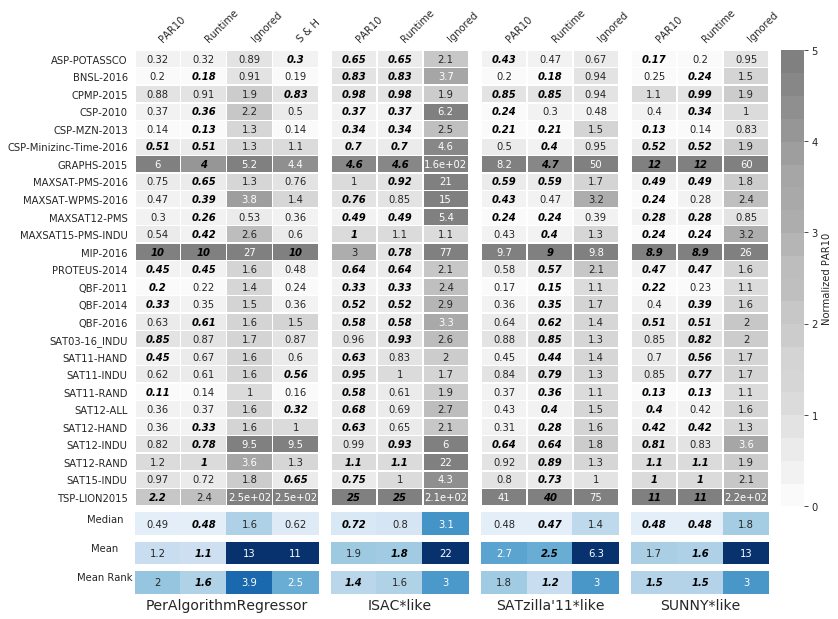

In [133]:
# Load Schmee & Hahn for PerAlgorithmRegressor
schmee_data = pd.read_csv(r'./schmee_normalized_par10.csv')
schmee_data.columns = ['ASlib Scenarios', 'Algorithm Selector', 'metric', 'normalized', 'num_results']
schmee_data = schmee_data[schmee_data['Algorithm Selector'] == 'ImputedPerAlgorithmRegressor']
schmee_data = schmee_data.set_index(keys='ASlib Scenarios', drop=True)
schmee_data = schmee_data['normalized']

# Load setting comparison data
data = pd.read_csv(r'./setting_comparison_normalized_par10.csv')
data.columns = ['ASlib Scenario', 'Algorithm Selector', 'Metric', 'PAR10', 'Runtime', 'Ignored']

approaches = ['PerAlgorithmRegressor', 'ISAC*like', 'SATzilla\'11*like', 'SUNNY*like']
fig = plt.figure(figsize=(12, 10), constrained_layout=False)
num_cols = len(approaches) + 1
width_ratios = [30 for _ in range(len(approaches))]
width_ratios[0] = 40
width_ratios.append(5)

gs1 = gridspec.GridSpec(4, num_cols, width_ratios=width_ratios, height_ratios=[100, 5, 5, 5], figure=fig, wspace=0.1, hspace=0.05)
gs2 = gridspec.GridSpec(4, num_cols, width_ratios=width_ratios, height_ratios=[100, 5, 5, 5], figure=fig, wspace=0.1, hspace=0.05)

axes1 = [fig.add_subplot(gs1[0, num]) for num in range(num_cols)]


axes2 = [fig.add_subplot(gs2[1, num]) for num in range(num_cols - 1)]
axes3 = [fig.add_subplot(gs2[2, num]) for num in range(num_cols - 1)]
axes4 = [fig.add_subplot(gs2[3, num]) for num in range(num_cols - 1)]

palette = sns.color_palette(['#FAFAFA', '#F2F2F2', '#EBEBEB', '#E3E3E3', '#DBDBDB', '#D6D6D6', '#D4D4D4', '#CCCCCC', '#C7C7C7', '#BFBFBF', '#BDBDBD', '#B5B5B5', '#ADADAD', '#A9A9A9', '#A6A6A6', '#9E9E9E', '#969696', '#8F8F8F', '#878787', '#808080'], n_colors=20)
bottom_palette =sns.color_palette("Blues", n_colors=100)
vmin, vmax = 0.0, 5.0

for num, approach in tqdm(enumerate(approaches)):
    tmp_data = data.copy()
    tmp_data = tmp_data[tmp_data['Algorithm Selector'] == approach]
    columns = ['PAR10', 'Runtime', 'Ignored']
    
    if approach == 'PerAlgorithmRegressor':
        tmp_data = tmp_data.set_index('ASlib Scenario', drop=False)
        tmp_data = pd.concat([tmp_data, schmee_data], axis=1, sort=True)
        columns.extend(['S & H'])
        tmp_col = ['ASlib Scenario','Algorithm Selector', 'Metric']
        tmp_col.extend(columns)
        tmp_data.columns = tmp_col

    tmp_data = tmp_data.pivot('ASlib Scenario','Algorithm Selector', columns)
    tmp_data.columns = columns
    
    if num + 1 < len(approaches):
        sns.heatmap(tmp_data, cmap=palette, linewidths=.5, ax=axes1[num], annot=True, cbar_kws={'label': 'Normalized PAR10'}, vmax=vmax, vmin=vmin, cbar=False)
    
    else:
        sns.heatmap(tmp_data, cmap=palette, linewidths=.5, ax=axes1[num], annot=True, cbar_kws={'label': 'Normalized PAR10'}, vmax=vmax, vmin=vmin, cbar_ax=axes1[-1])

    axes1[num].tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, top=False, labeltop=True)
    labels = axes1[num].get_xticklabels()
    axes1[num].set_xticklabels(labels, rotation=45, ha='left')
    axes1[num].set_xlabel('')
    axes1[num].set_ylabel('')    
    
    tmp = np.asarray(tmp_data.values, dtype=float)
    median = np.median(tmp, axis=0)    
    median = median.reshape(1, median.size)
    mean = np.mean(tmp, axis=0)
    mean = mean.reshape(1, mean.size)
    ranks = rankdata(tmp, axis=1)
    ranks = np.mean(ranks, axis=0)
    ranks = ranks.reshape(1, ranks.size)

    sns.heatmap(median, ax=axes2[num], annot=True, cbar=False, xticklabels=False, yticklabels=False, cmap=bottom_palette, vmin=0.0, vmax=vmax)
    sns.heatmap(mean, ax=axes3[num], annot=True, cbar=False, xticklabels=False, yticklabels=False, cmap=bottom_palette, vmin=0.0, vmax=vmax)
    sns.heatmap(ranks, ax=axes4[num], annot=True, cbar=False, xticklabels=False, yticklabels=False, cmap=bottom_palette, vmin=0.0, vmax=vmax)
    
    num_scenarios, num_settings = tmp.shape
    for scenario_id in range(num_scenarios):
        tmp_texts = axes1[num].texts[scenario_id * num_settings: scenario_id* num_settings + num_settings]
        min_val = min([float(text.get_text()) for text in tmp_texts])
        texts = [text for text in tmp_texts if float(text.get_text()) == min_val]
        
        for text in texts:
            #text.set_size(12)
            text.set_weight('bold')
            text.set_color('black')
            text.set_style('italic')

    
    for ax in [axes2[num], axes3[num], axes4[num]]:
        min_val = min([float(text.get_text()) for text in ax.texts])
        indices = [num for num, text in enumerate(ax.texts) if float(text.get_text()) == min_val]

        for idx in indices:
            text = ax.texts[idx]
            #text.set_size(12)
            text.set_weight('bold')
            text.set_color('black')
            text.set_style('italic')
    
    
    if num > 0:
        axes1[num].axes.get_yaxis().set_visible(False)

#for ax in axes1[:-1]:
#    bottom, top = ax.get_ylim()
#    ax.set_ylim(bottom + 0.5, top - 0.5)
    
for num, ax in enumerate(axes2):
    ax.set_xlabel('')
    ax.set_ylabel('')
    
axes2[0].set_ylabel('Median', rotation=0, labelpad=30)
    
for ax in axes3:
    ax.set_xlabel('')
    ax.set_ylabel('')
    
axes3[0].set_ylabel('Mean', rotation=0, labelpad=30)

for num, ax in enumerate(axes4):
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xlabel(approaches[num], y=1.3, fontsize=14)

axes4[0].set_ylabel('Mean Rank', rotation=0, labelpad=30)

fig.savefig(r'./setting_comparison.pdf', bbox_inches='tight')
plt.show()

### Unsolved Table

In [46]:
survival_data = pd.read_csv(r'./unsolved_final.csv')


name_map = {'Expectation_algorithm_survival_forest':'ExpectationSurvivalForest', 
            'SurrogateAutoSurvivalForest':'RiskAverseSurvivalForest',
           'GridSearch_algorithm_survival_forest':'GridSearchSurvivalForest',
           'PAR10_algorithm_survival_forest':'PAR10SurvivalForest',
           'isac':'ISAC*like\n(PAR10)',
           'multiclass_algorithm_selector':'MultiClassSelector',
           'per_algorithm_regressor':'PerAlgorithmRegressor\n(Runtime)',
           'satzilla-11':'SATzilla\'11*like\n(Runtime)',
           'snnap':'SNNAP*like',
           'sunny':'SUNNY*like\n(Runtime)'}

delete = ['MultiClassSelector', 'SNNAP*like', 'GridSearchSurvivalForest', 'sbs','ISAC*like\n(PAR10)', 'PerAlgorithmRegressor\n(Runtime)', 'SATzilla\'11*like\n(Runtime)', 'SUNNY*like\n(Runtime)']

survival_data = survival_data.replace(name_map)
survival_data = survival_data[~survival_data['Algorithm Selector'].isin(delete)]
survival_data = survival_data.drop('metric', axis=1)
survival_data.to_csv(r'./unsolved_final.csv', index=False)

In [50]:
### For each baseline select results from the overall best setting (PAR10, Runtime or Ignored) in terms of median performance aggregated over all scenarios 

# get data for own approaches from unsolved instances table
survival_data = pd.read_csv(r'./unsolved_final.csv')
survival_data = survival_data.pivot('ASlib Scenario','Algorithm Selector','unsolved')
survival_data = survival_data[['ExpectationSurvivalForest', 'PAR10SurvivalForest', 'RiskAverseSurvivalForest']]

# get data for baselines from the comparison unsolved instances (best value from different settings)
baseline_data =  pd.read_csv(r'./setting_comparison_unsolved.csv')
min_median_setting = baseline_data.groupby(['Algorithm Selector', 'Metric']).median().idxmin(axis=1)
min_median_setting = min_median_setting.droplevel(level=1)
min_median_setting = list(zip(min_median_setting.index, min_median_setting))
baseline_map = dict(min_median_setting).copy()
baseline_data = baseline_data.pivot('ASlib Scenario', 'Algorithm Selector', ['PAR10', 'Runtime', 'Ignored']).swaplevel(axis=1).sort_index(1)
baseline_data = baseline_data[min_median_setting]
baseline_data = baseline_data.droplevel(axis=1, level=1)

# add Schmee & Hahn for PerAlgorithmRegressor and recompute min median for unsolved instances metric
schmee_data = pd.read_csv(r'./schmee_unsolved.csv')
schmee_data = schmee_data[schmee_data['Algorithm Selector'] == 'ImputedPerAlgorithmRegressor']
schmee_data = schmee_data.set_index(keys='ASlib Scenario', drop=True)

if schmee_data['unsolved'].median() < baseline_data['PerAlgorithmRegressor'].median():
    baseline_data['PerAlgorithmRegressor'] = schmee_data['normalized']
    baseline_map['PerAlgorithmRegressor'] = 'S & H'
    
# adjust ordering of algorithms and rename according to best setting
baseline_data = baseline_data[['PerAlgorithmRegressor', 'MultiClassSelector', 'ISAC*like', 'SATzilla\'11*like', 'SUNNY*like']]

data = pd.concat([survival_data, baseline_data], axis = 1).T.drop_duplicates().T
baseline_index = [''.join([selector, '\n(' + baseline_map[selector] + ')']) for selector in data.columns if selector in baseline_map.keys()]
data = data.rename(columns={selector: ''.join([selector, '\n(' + setting + ')']) for selector, setting in baseline_map.items()})

data = data*100
data = data.round(1)
data.to_latex('median_unsolved_table.tex')
data

Algorithm Selector,ExpectationSurvivalForest,PAR10SurvivalForest,RiskAverseSurvivalForest,PerAlgorithmRegressor\n(Runtime),MultiClassSelector\n(Runtime),ISAC*like\n(PAR10),SATzilla'11*like\n(Runtime),SUNNY*like\n(PAR10)
ASlib Scenario,,,,,,,,
ASP-POTASSCO,2.2,2.6,2.3,2.4,5.5,5.3,3.7,1.3
BNSL-2016,2.4,2.5,2.2,2.0,3.8,10.0,2.2,3.0
CPMP-2015,15.8,13.5,14.8,14.4,15.4,16.7,14.0,18.2
CSP-2010,0.6,0.6,0.5,0.7,1.5,0.9,0.6,0.8
CSP-MZN-2013,3.5,3.6,3.5,4.0,10.6,11.6,7.0,4.0
CSP-Minizinc-Time-2016,8.7,8.7,8.7,8.4,8.4,9.8,7.4,8.8
GRAPHS-2015,0.5,0.5,0.5,0.6,1.1,0.7,0.8,0.5
MAXSAT-PMS-2016,2.5,2.0,2.7,3.2,5.6,4.9,2.9,2.3
MAXSAT-WPMS-2016,3.9,3.5,3.3,3.5,7.2,6.1,3.7,2.4


In [53]:
data.median()

Algorithm Selector
ExpectationSurvivalForest           4.50
PAR10SurvivalForest                 4.15
RiskAverseSurvivalForest            4.05
PerAlgorithmRegressor\n(Runtime)    4.95
MultiClassSelector\n(Runtime)       7.80
ISAC*like\n(PAR10)                  8.45
SATzilla'11*like\n(Runtime)         5.95
SUNNY*like\n(PAR10)                 4.80
dtype: float64

### ASlib Scenario overview table

In [32]:
from aslib_scenario.aslib_scenario import ASlibScenario

aslib_table = pd.DataFrame(columns=['Scenario', '#I', '#U', '#A', '#F', 'T', '%C'])

scenarios = ['ASP-POTASSCO', 'BNSL-2016', 'CPMP-2015', 'CSP-2010',
       'CSP-MZN-2013', 'CSP-Minizinc-Time-2016', 'GRAPHS-2015',
       'MAXSAT-PMS-2016', 'MAXSAT-WPMS-2016', 'MAXSAT12-PMS',
       'MAXSAT15-PMS-INDU', 'MIP-2016', 'PROTEUS-2014', 'QBF-2011',
       'QBF-2014', 'QBF-2016', 'SAT03-16_INDU', 'SAT11-HAND',
       'SAT11-INDU', 'SAT11-RAND', 'SAT12-ALL', 'SAT12-HAND',
       'SAT12-INDU', 'SAT12-RAND', 'SAT15-INDU', 'TSP-LION2015']

for num, scenario_name in enumerate(scenarios):
    scenario = ASlibScenario()
    scenario.read_scenario('/workspaces/aslib/' + scenario_name)
    
    name = str(scenario.scenario)
    instances = len(scenario.instances)
    algorithms = len(scenario.algorithms)
    features = len(scenario.feature_data.columns)
    timeout = scenario.algorithm_cutoff_time
    
    performance_data = scenario.performance_data.values
    censored = (np.sum(performance_data >= timeout) / performance_data.size) * 100
    unsolved = np.sum(np.all((performance_data >= timeout), axis=1))
    
    aslib_table.loc[num] = [name, instances, unsolved, algorithms, features, timeout, censored]
    
aslib_table = aslib_table.round(1)
aslib_table = aslib_table.set_index('Scenario', drop=True)
aslib_table = aslib_table.T
aslib_table.to_latex('aslib_table.tex')

Optional file not found: /workspaces/aslib/ASP-POTASSCO/ground_truth.arff
Have not found algorithm_cutoff_memory
Have not found features_cutoff_memory
Have not found features_stochastic
Found 37 duplicated feature vectors
Index(['FolioSuite/ASP-Comp-2007-Lparse/SLparse/CarSequencing/001.benchmark1_17classes.dlv.dat.lp.gz',
       'FolioSuite/ASP-Comp-2007-Lparse/SLparse/HamiltonianPath/gryzzles.15.gz',
       'FolioSuite/ASP-Comp-2007-Lparse/SLparse/HamiltonianPath/gryzzles.30.gz',
       'FolioSuite/ASP-Comp-2007-Lparse/SLparse/HamiltonianPath/hampath.ngrnd.6.gz',
       'FolioSuite/ASP-Comp-2007-Lparse/SLparse/Hashiwokakero/hashiwokakero-size11-puzzle5.gz',
       'FolioSuite/ASP-Comp-2007-Lparse/SLparse/SolitaireBackward2/t29.dat.gz',
       'FolioSuite/ASP-Comp-2007-Lparse/SLparse/Su-Doku/sudoku378.lp.gz',
       'FolioSuite/ASP-Comp-2007-Lparse/SLparse/WeightBoundedDominatingSetSuite/rand_150_600_1159731678_7.gph.gz',
       'FolioSuite/ASP-Comp-2007-Lparse/SLparse/searchTest-plai

### Pie Charts

In [ ]:
from aslib_scenario.aslib_scenario import ASlibScenario

aslib_table = pd.DataFrame(columns=['Scenario', '#I', '#U', '#A', '#F', 'T', '%C'])

scenarios = ['ASP-POTASSCO', 'BNSL-2016', 'CPMP-2015', 'CSP-2010',
       'CSP-MZN-2013', 'CSP-Minizinc-Time-2016', 'GRAPHS-2015',
       'MAXSAT-PMS-2016', 'MAXSAT-WPMS-2016', 'MAXSAT12-PMS',
       'MAXSAT15-PMS-INDU', 'MIP-2016', 'PROTEUS-2014', 'QBF-2011',
       'QBF-2014', 'QBF-2016', 'SAT03-16_INDU', 'SAT11-HAND',
       'SAT11-INDU', 'SAT11-RAND', 'SAT12-ALL', 'SAT12-HAND',
       'SAT12-INDU', 'SAT12-RAND', 'SAT15-INDU', 'TSP-LION2015']

for num, scenario_name in enumerate(scenarios):
    scenario = ASlibScenario()
    scenario.read_scenario('/workspaces/aslib/' + scenario_name)
    
    name = str(scenario.scenario)
    instances = len(scenario.instances)
    algorithms = len(scenario.algorithms)
    features = len(scenario.feature_data.columns)
    timeout = scenario.algorithm_cutoff_time
    
    performance_data = scenario.performance_data.values
    censored = (np.sum(performance_data >= timeout) / performance_data.size) * 100
    unsolved = np.sum(np.all((performance_data >= timeout), axis=1))
    
    aslib_table.loc[num] = [name, instances, unsolved, algorithms, features, timeout, censored]
    
aslib_table = aslib_table.round(1)
aslib_table = aslib_table.set_index('Scenario', drop=True)
aslib_table = aslib_table.T
aslib_table.to_latex('aslib_table.tex')

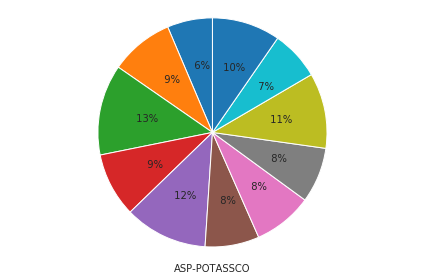

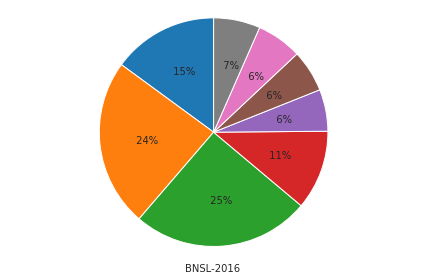

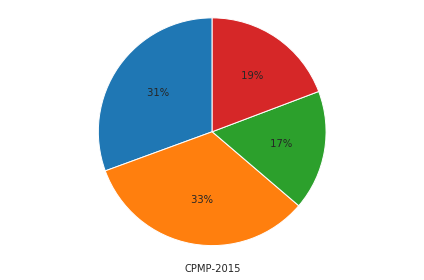

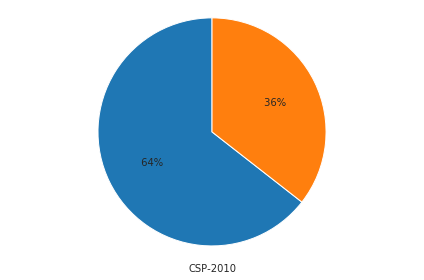

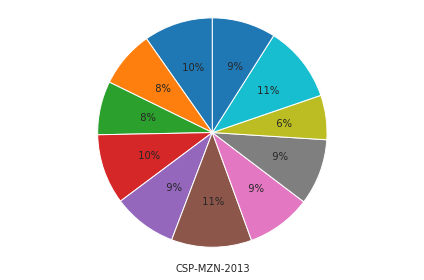

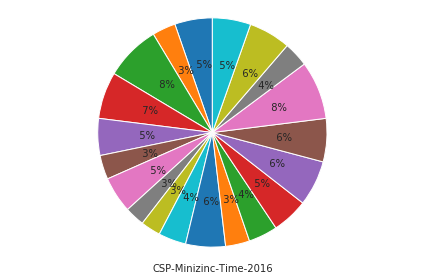

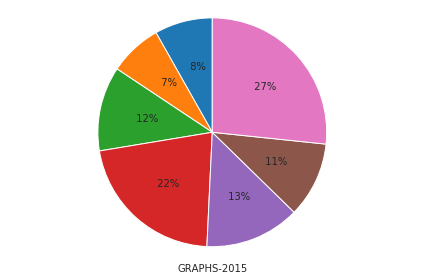

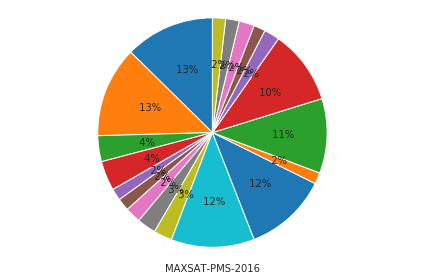

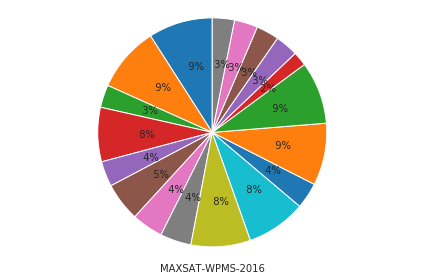

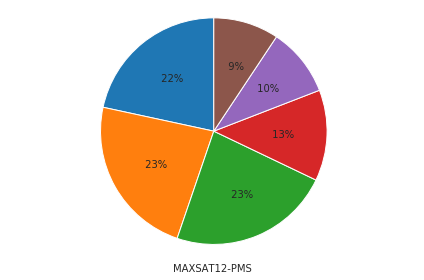

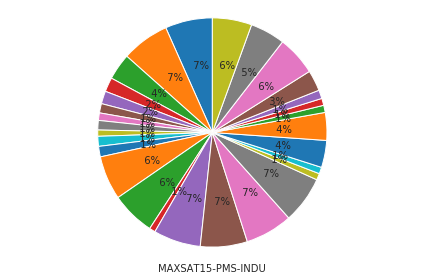

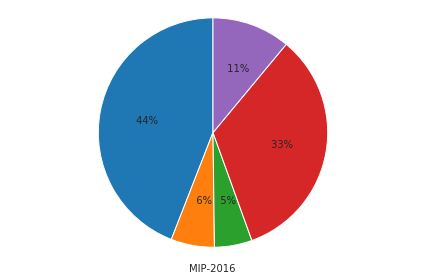

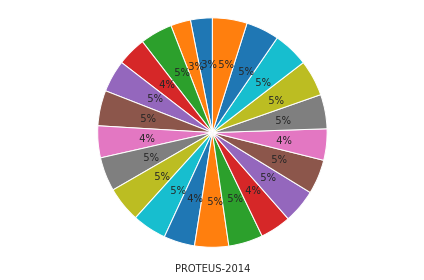

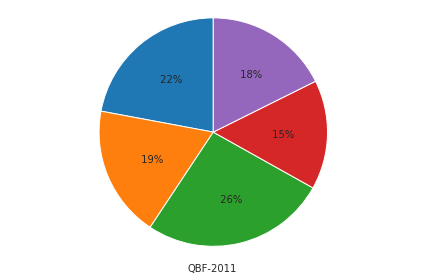

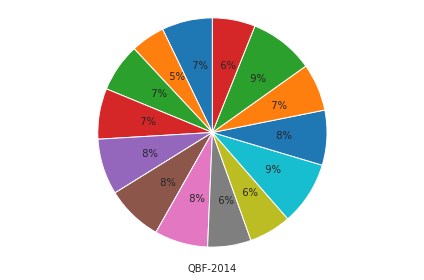

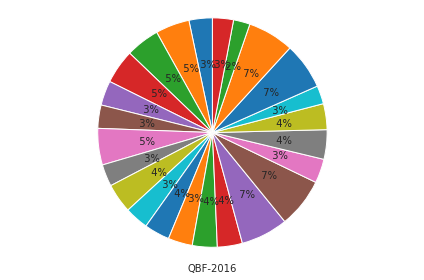

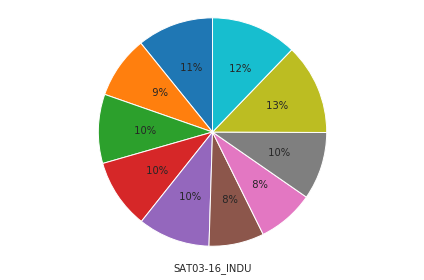

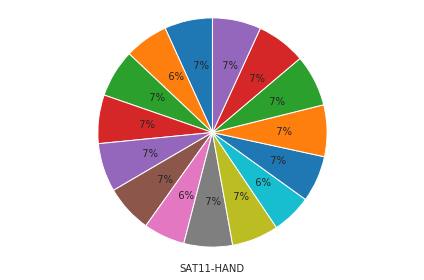

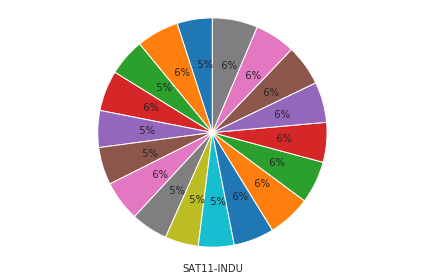

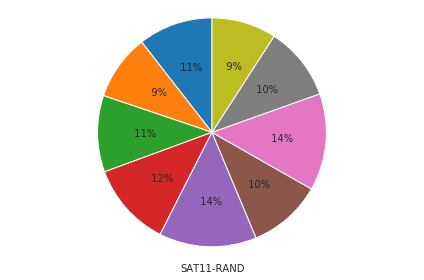

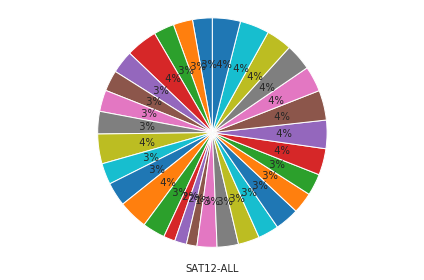

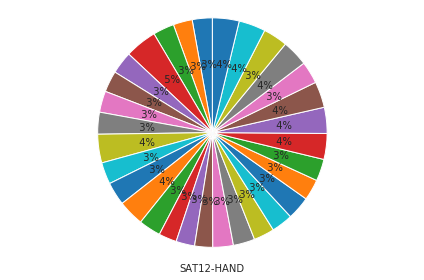

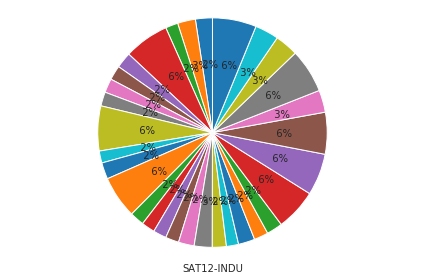

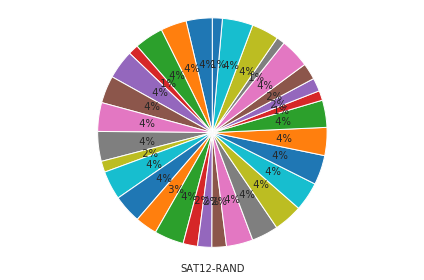

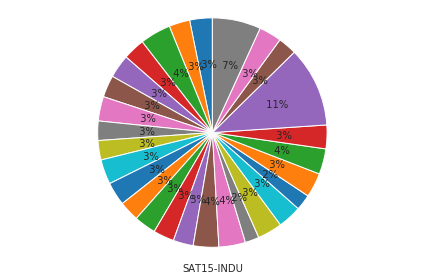

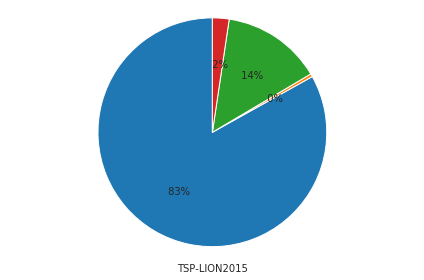

In [254]:
import math
import sys
import os

for num, scenario_name in enumerate(scenarios):
    sys.stdout = open(os.devnull, "w")
    sys.stderr = open(os.devnull, "w")
    
    scenario = ASlibScenario()
    scenario.read_scenario('/workspaces/aslib/' + scenario_name)
    
    sys.stdout = sys.__stdout__
    sys.stderr = sys.__stderr__
    
    performance_data = scenario.performance_data.values
    censored = (np.sum(performance_data >= timeout) / performance_data.size)
    per_alg_censored = (np.sum(performance_data >= timeout, axis= 0) / performance_data.size) / censored
    
    fig, ax = plt.subplots()
    sizes = per_alg_censored
    #cs=cm.Set1(np.arange(sizes.size)/sizes.size, alpha=0.7)

    ax.pie(sizes, autopct='%3.0f%%',
        shadow=False, startangle=90)
    
    ax.axis('equal')
    ax.set_xlabel(scenario_name)
    

    plt.tight_layout()
    fig.savefig(r'./pie_charts/' + scenario_name + '.pdf', bbox_inches='tight')

In [54]:
matr = np.asarray([[5, 12, 30, 20, 15],
           [20, 4, 15, 10, 25],
           [15, 20, 6, 15, 12],
           [25, 15, 25, 4, 10],
           [10, 25, 15, 12, 5]])

In [57]:
matr[:,0] *= 2
matr[:,1] *= 1
matr[:,2] *= 3
matr[:,3] *= 1
matr[:,4] *= 3

In [62]:
from itertools import chain, combinations

In [64]:
for i in range(5):
    for j in range(i+1, 5):
        # i,j placement combination
        s = set(range(5)).difference(set([i,j]))
        print(i,j)
        print(s)
        print()
        # iterate all possible assignments
        for k in chain.from_iterable(combinations(s, r) for r in range(len(s)+1))
        

SyntaxError: invalid syntax (<ipython-input-64-ec7a18d7e1ad>, line 9)

In [63]:
chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

NameError: name 's' is not defined